In [1]:
import sys  
sys.path.insert(0, '/Users/navinlr/Desktop/Thesis/code_base/conversation_quality')

In [2]:
from dataset_creation import dataset_creator as data_generator

import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

sns.set(rc={'figure.figsize':(11.7,8.27)})

Total Groups = 115


/Users/navinlr/opt/anaconda3/envs/conversation_quality/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.4, the latest is 0.3.6.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
# TEST Variables
agreeability_thresh=.2
manifest="group"
annotators=["Divya", "Nakul"]#, "Swathi"]
zero_mean  = False

test_feats = ["const", "group_sizes"] 

In [4]:
# Annotation Reader
reliable_ids, reliable_convqs, reliable_kappas = data_generator.get_annotation_realiable_labels(agreeability_thresh, manifest, annotators, zero_mean)
print("Total Groups in Analysis - " + str(len(reliable_ids)))

ZERO-MEAN Technique ? - False
ZERO-MEAN Technique ? - False
Total Groups in Analysis - 81


In [5]:
# Get groups sizes (for indiv and group)
group_sizes = data_generator.get_group_sizes_for_ids(reliable_ids, manifest)

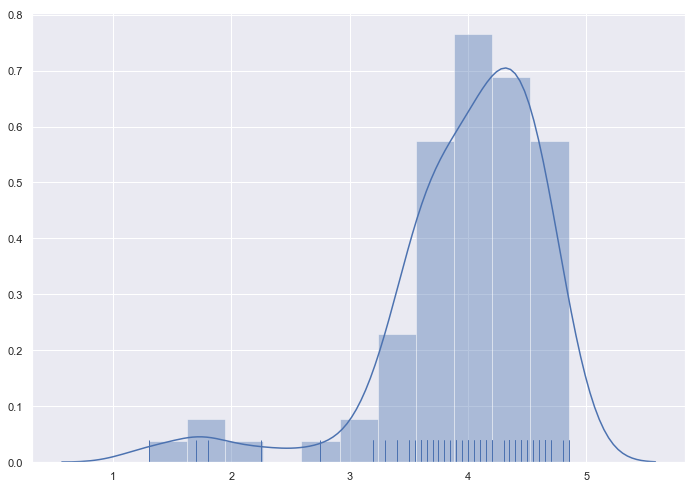

In [6]:
# Plots - Qualitative Analysis
sns.distplot(reliable_convqs, kde=True, rug=True)
plt.show()

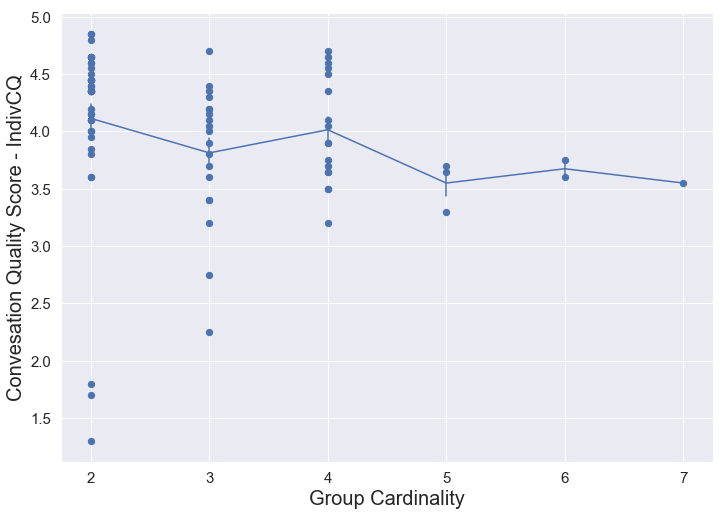

In [7]:
# Scatter Plot - Grp Size Vs ConvQ
plt.scatter(group_sizes, reliable_convqs,s=40,c='b')
sns.lineplot(x=group_sizes, y=reliable_convqs, err_style="bars", ci=68)
plt.ylabel('Convesation Quality Score - IndivCQ', fontsize=20)
plt.xlabel('Group Cardinality', fontsize=20)
plt.tick_params(labelsize=15)
plt.show()

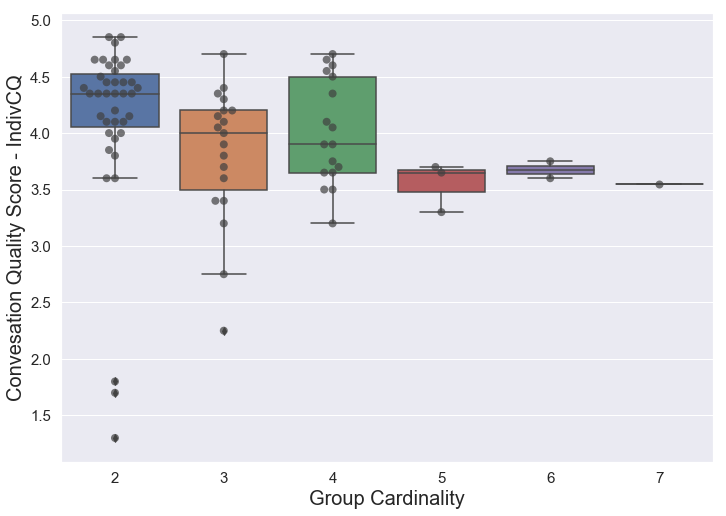

In [8]:
sns.boxplot(group_sizes, reliable_convqs)
sns.swarmplot(group_sizes, reliable_convqs,s=8, color=".25", alpha=0.7)
plt.ylabel('Convesation Quality Score - IndivCQ', fontsize=20)
plt.xlabel('Group Cardinality', fontsize=20)
plt.tick_params(labelsize=15)
plt.show()

In [9]:
# Dataset Prep
gs_X = pd.DataFrame(data=group_sizes, index=reliable_ids, columns=["group_sizes"]) 
gs_X["convq"] = reliable_convqs

In [10]:
# Experiment Below

# Statistical Test for: (Main Question)
# Does group-size have an effect on the Percieved Conversation Quality of the Group?
#
# 1. Validate Significance @ p<0.05 using a Quantile Least Square based Regression (group_size Vs ConvQ)
# 2. Validate futher for Significance @ p<0.05 with pairs of group-sizes. (Pairwise Quantile LS Tests)
# 3. Check the co-efficients for relationships.

# Quantile Regression
X = sm.add_constant(gs_X)
# model = sm.OLS(X["convq"], X.loc[:,test_feats])
model = sm.regression.quantile_regression.QuantReg(X["convq"], X.loc[:,test_feats])
results = model.fit()
print(results.summary())

                         QuantReg Regression Results                          
Dep. Variable:                  convq   Pseudo R-squared:               0.1105
Model:                       QuantReg   Bandwidth:                      0.4896
Method:                 Least Squares   Sparsity:                        1.154
Date:                Fri, 03 Jul 2020   No. Observations:                   81
Time:                        11:38:45   Df Residuals:                       79
                                        Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.7833      0.179     26.676      0.000       4.426       5.140
group_sizes    -0.2167      0.057     -3.785      0.000      -0.331      -0.103


In [11]:
# Pairwise Quantile Regression
unique_groups = np.unique(X.loc[:,"group_sizes"].values)
for pair in list(itertools.combinations(unique_groups,2)):
    pairwise_X = X.loc[X["group_sizes"].isin(list(pair))]
    model = sm.regression.quantile_regression.QuantReg(pairwise_X["convq"], pairwise_X.loc[:,test_feats])
    results = model.fit(q=.4)
    print("Current Pair -> " + str(list(pair)))
    print(results.summary())

Current Pair -> [2, 3]
                         QuantReg Regression Results                          
Dep. Variable:                  convq   Pseudo R-squared:              0.04348
Model:                       QuantReg   Bandwidth:                      0.5813
Method:                 Least Squares   Sparsity:                        1.336
Date:                Fri, 03 Jul 2020   No. Observations:                   58
Time:                        11:38:45   Df Residuals:                       56
                                        Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.0000      0.438     11.428      0.000       4.124       5.876
group_sizes    -0.4000      0.184     -2.169      0.034      -0.769      -0.031
Current Pair -> [2, 4]
                         QuantReg Regression Results                          
De

Current Pair -> [4, 5]
                         QuantReg Regression Results                          
Dep. Variable:                  convq   Pseudo R-squared:              0.02346
Model:                       QuantReg   Bandwidth:                      0.9846
Method:                 Least Squares   Sparsity:                        1.748
Date:                Fri, 03 Jul 2020   No. Observations:                   20
Time:                        11:38:45   Df Residuals:                       18
                                        Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.1500      2.187      1.897      0.074      -0.445       8.745
group_sizes    -0.1000      0.524     -0.191      0.851      -1.201       1.001
Current Pair -> [4, 6]
                         QuantReg Regression Results                          
De

/Users/navinlr/opt/anaconda3/envs/conversation_quality/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:235: RuntimeWarning: invalid value encountered in less_equal
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/navinlr/opt/anaconda3/envs/conversation_quality/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/navinlr/opt/anaconda3/envs/conversation_quality/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/navinlr/opt/anaconda3/envs/conversation_quality/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [12]:
from scipy import stats

In [16]:
rank_feature_names=[]
rank_correl=[]
rank_pvalue=[]

# print(X["convq"].values)
# print(X.loc[:,test_feats].values)

for feat_i in test_feats:
    if feat_i != "const":
        correl, p_value = stats.spearmanr(X["convq"].values, X.loc[:,feat_i].values)
        rank_feature_names.append(feat_i)
        rank_correl.append(round(correl,5))
        rank_pvalue.append(round(p_value, 5))

In [17]:
data = {"Feature Name" : rank_feature_names,
       "Spearman Correlation": rank_correl,
       "p-value": rank_pvalue}

report_df = pd.DataFrame.from_dict(data)

In [18]:
print(report_df)
report_df.to_csv("group_size-rank-group.csv", index=True)

  Feature Name  Spearman Correlation  p-value
0  group_sizes              -0.36169  0.00091
